In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.stats as ss
import math

# Question formulation 
### Assume you have USD100,000. You are looking at trading Coke and Pepsi. Assume cash earns 5% per year in the bank.

### On the 9th of October 2023, at the close of the market, assume you short sell USD100,000 shares of Coke stock, use the proceeds to buy USD100,000 shares of Pepsi.
### Simulate 1,000,000 daily paths of the pairs trade for the next 3 months (60 trading days). Be explicit with all the assumptions you make on the random walks you generate and how you think about their correlation and mean-reversion.
### If we enter the trade on the 9th what is the expected value of the trade on the 16th? What is the 5th and 95th percentile profit-loss? At what price differential would you enter this pairs trade, at what price would you exit? Why?


# Data
As of 4th October 2023, the closing price of Coke is USD 55.10, Implied volatility 18.75%, Dividend yield 3.29%, 
As of 4th October 2023, the closing price of Pepsi is USD 167.98, Implied volatility 22.00%, Dividend yield 2.85%, 
we use past 10 years data to work out the correlation between the two stocks are 0.73

In [2]:
ticker = ['KO', 'PEP']
historical_data = yf.download(ticker, start='2013-10-04', end='2023-10-04')

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

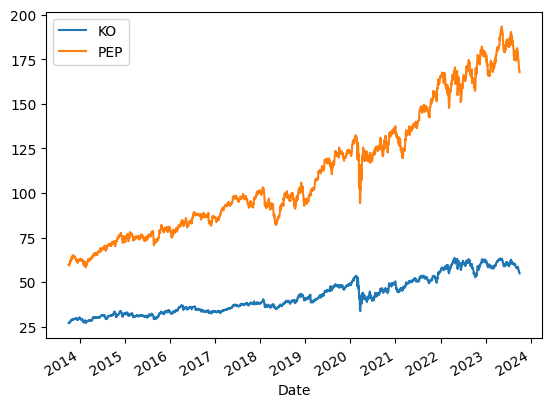

In [3]:
historical_data = historical_data.loc[:, 'Adj Close']
historical_data.plot()

In [4]:
corr_mat = (historical_data.pct_change().corr())
corr_mat

,KO,PEP
KO,1.00000,0.73668
PEP,0.73668,1.00000


# Monte Carlo Simulation forecast

In [5]:
np.random.seed(1)

In [6]:
S0_ko = historical_data.iloc[-1, 0]  # using the last value
S0_pep = historical_data.iloc[-1, 1]  # using the last value
# sigma_ko = historical_data['KO'].pct_change().std()# using historical volatility
# sigma_pep = historical_data['PEP'].pct_change().std()# using historical volatility
# mu_ko = historical_data['KO'].pct_change().mean()# using historical average daily return
# mu_pep = historical_data['PEP'].pct_change().mean()# using historical average daily return

In [7]:
mu_ko = 0.0329
mu_pep = 0.0285
sigma_ko = 0.1875
sigma_pep = 0.22

In [8]:
T = 1
NTrials = 1_000_000
# NTrials = 10000
# daily experiment
NSteps = 252
dt = T / NSteps
t = np.linspace(0, T, NSteps)

In [9]:
# we are only looking for 60 trading days
U_ko = np.random.uniform(size=(NTrials, 60))
U_pep = np.random.uniform(size=(NTrials, 60))
dW_ko = ss.norm.ppf(U_ko)
dW_pep = ss.norm.ppf(U_pep)

In [10]:
L = np.linalg.cholesky(corr_mat)

In [11]:
for i in range(NTrials):
    temp = np.stack([dW_ko[i], dW_pep[i]]).T @ L.T
    dW_ko[i], dW_pep[i] = temp[:, 0], temp[:, 1]

In [12]:
# confirm the correlation between two random number is 0.73
pd.DataFrame([dW_ko.reshape(-1)[:1000], dW_pep.reshape(-1)[:1000]]).T.corr()

,0,1
0,1.000000,0.724836
1,0.724836,1.000000


In [13]:
# simulate the stock price using Geometric Brownian Motion
dS_ko = mu_ko * dt + sigma_ko * dW_ko * np.sqrt(dt)
dS_pep = mu_pep * dt + sigma_pep * dW_pep * np.sqrt(dt)
S_ko = S0_ko * np.cumprod(1 + dS_ko, axis=1)
S_pep = S0_pep * np.cumprod(1 + dS_pep, axis=1)

In [14]:
# # simulate the stock price using Arithmetic Brownian Motion
# dS_ko = mu_ko *dt+ sigma_ko * dW_ko 
# dS_pep = mu_pep *dt+ sigma_pep * dW_pep
# S_ko = S0_ko + np.cumsum(dS_ko, axis=1)
# S_pep = S0_pep + np.cumsum(dS_pep, axis=1)

In [15]:
def plot_simulations(arr, name, extra_plot=True):
    plt.figure(figsize=(20, 4))
    if extra_plot:
        plt.subplot(1, 3, 1)
        for sim in arr[:1000]:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.subplot(1, 3, 2)
        plt.plot(np.mean(arr, axis=0))
        plt.title(f'mean price simulation for {name}')
        plt.subplot(1, 3, 3)
        plt.plot(np.std(arr, axis=0))
        plt.title(f'std price simulation for {name}')
        plt.show()
    else:
        for sim in arr:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.show()

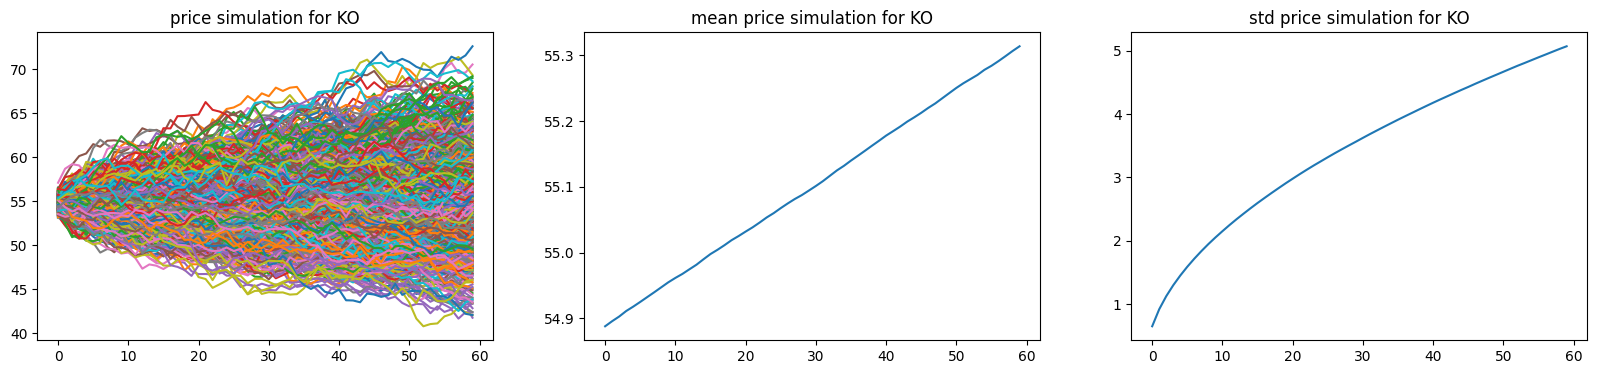

In [16]:
plot_simulations(S_ko, 'KO')

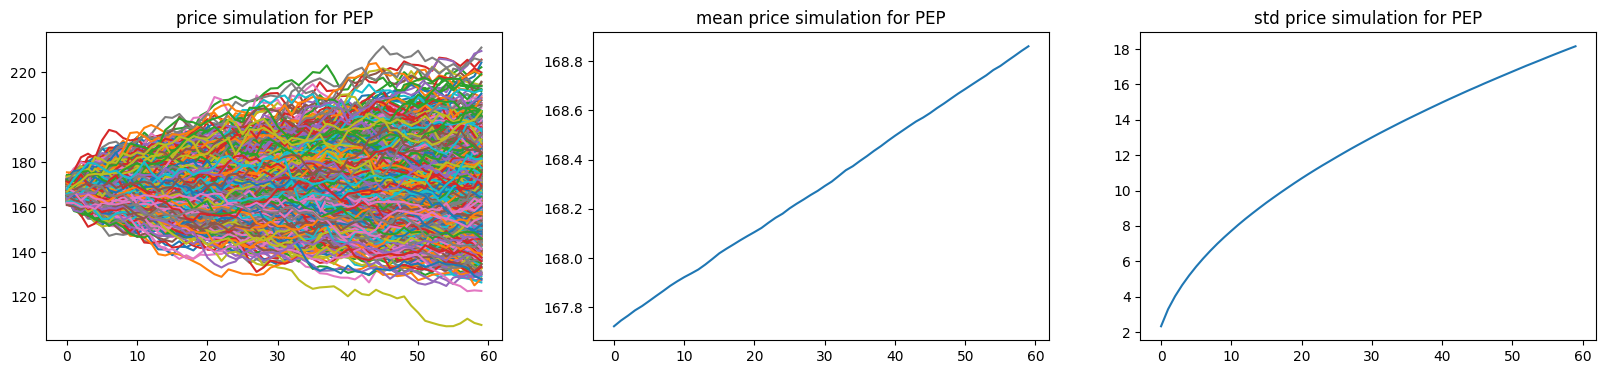

In [17]:
plot_simulations(S_pep, 'PEP')

In [18]:
spread = S_pep - S_ko

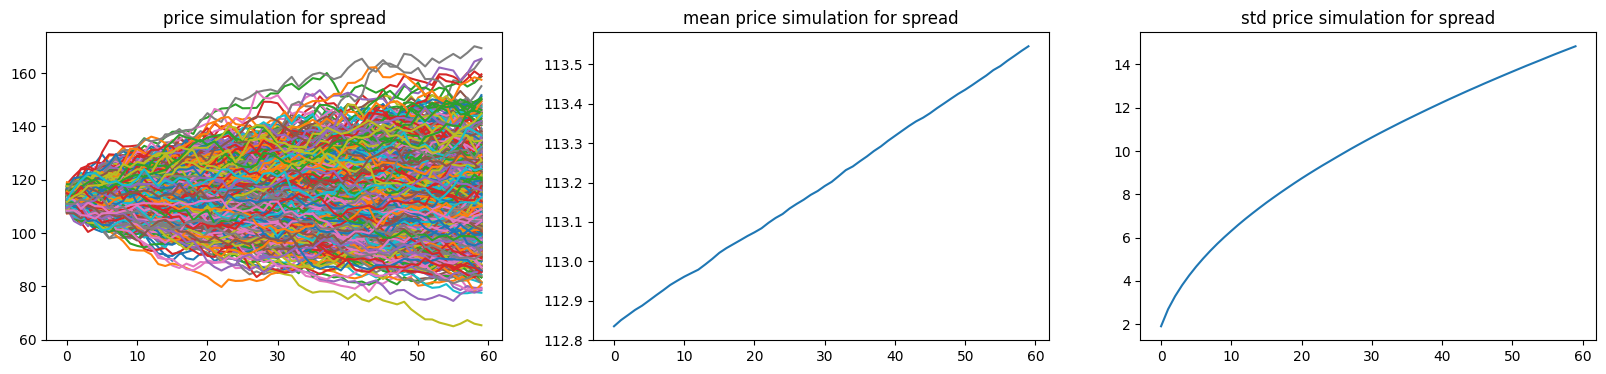

In [19]:
plot_simulations(spread, 'spread')

In [20]:
historical_spread = historical_data['PEP'] - historical_data['KO']

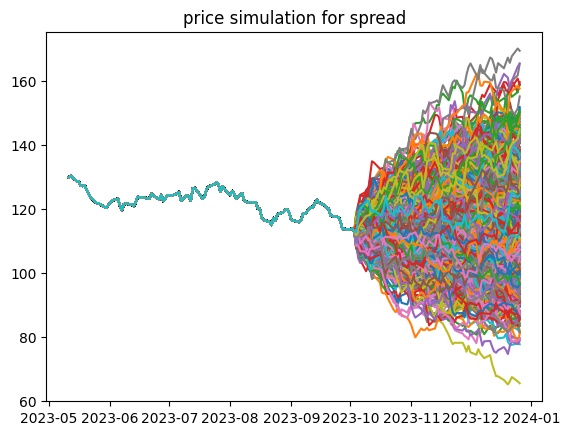

In [21]:
for sim in spread[:1000]:
    temp = pd.concat([historical_spread[-100:], pd.Series(sim, index=pd.bdate_range('2023-10-04', periods=60))])
    plt.plot(temp)
plt.title('price simulation for spread')
plt.show()

Text(0.5, 1.0, 'Confidence Interval for spread')

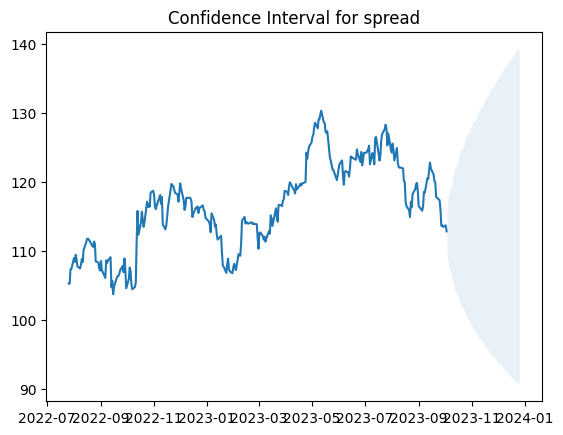

In [22]:
# Plot the Confidence interval for the spread:
plt.plot(historical_spread[-300:])
# plt.plot(historical_spread)
plt.fill_between(pd.bdate_range('2023-10-04', periods=60), np.quantile(spread, 0.05, axis=0),
                 np.quantile(spread, 0.95, axis=0), alpha=0.1)
plt.title('Confidence Interval for spread')

# If we enter the trade on the 9th what is the expected value of the trade on the 16th?

### Assumptions: 
### 1. Assume no transaction cost, slippage, it is not hard for us to short coke, we trade on the close price of 9th October
### 2. Assume we can only buy stocks 100 shares at a time, and we can only short stocks 100 shares at a time

In [23]:
num_short_pep = math.floor((100_000 / S0_pep) / 100) * 100
short_capital_gain = S0_pep * num_short_pep
num_long_ko = math.floor((short_capital_gain / S0_ko) / 100) * 100

In [24]:
print(f'number of PEP shares we short sell: {num_short_pep}')
print(f'amount of capital we have in short position: {num_short_pep * S0_pep}')
print(f'number of KO shares we long buy: {num_long_ko}')
print(f'amount of capital we have in long position: {num_long_ko * S0_ko}')
cash_reserve = num_short_pep * S0_pep - num_long_ko * S0_ko
print(f'cash reserve: {cash_reserve}')
long_pos = num_long_ko * S0_ko / (num_long_ko * S0_ko + num_short_pep * S0_pep)
short_pos = num_short_pep * S0_pep / (num_long_ko * S0_ko + num_short_pep * S0_pep)
print(f'percentage of capital we have in short pepsi position: {round(long_pos * 100, 2)}%')
print(f'percentage of capital we have in long coke position: {round(short_pos * 100, 2)}%')

number of PEP shares we short sell: 500
amount of capital we have in short position: 83849.9984741211
number of KO shares we long buy: 1500
amount of capital we have in long position: 82320.00160217285
cash reserve: 1529.9968719482422
percentage of capital we have in short pepsi position: 49.54%
percentage of capital we have in long coke position: 50.46%


In [25]:
cash_ret = (np.power((1 + 0.05), 1 / 4) - 1)

In [26]:
cash_ret

0.012272234429039353

### Initial position
at October 9th,
we have long coke position: 1500 stock
we have short pepsi position: 500 stocks
cash reserve: 1529.9 dollar 

In [27]:
position_return = long_pos * np.cumprod(1 + dS_ko, axis=1) - short_pos * np.cumprod(1 + dS_pep, axis=1)

In [28]:
position_value = num_long_ko * S_ko - num_short_pep * S_pep + cash_reserve * (1 + cash_ret)

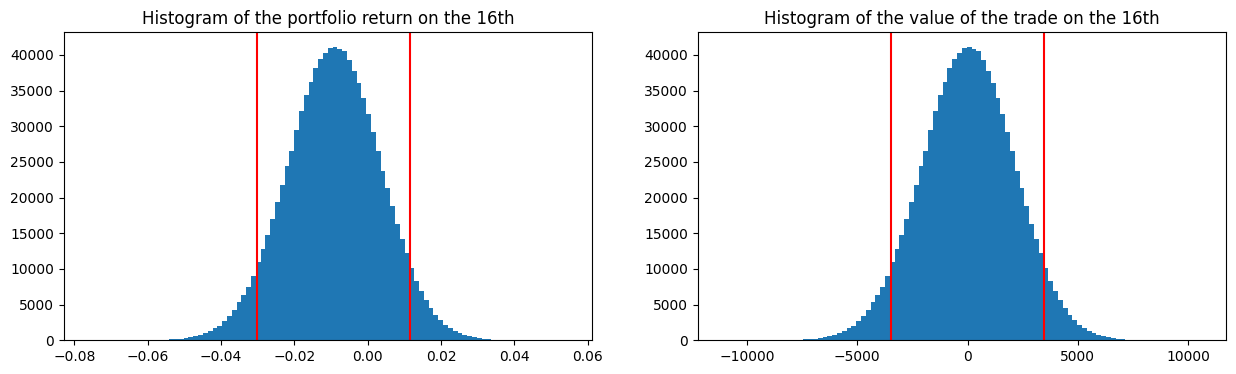

In [29]:
# the expected value of the trade on the 16th
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.hist(position_return[:, 6], bins=100)
plt.title('Histogram of the portfolio return on the 16th')
plt.axvline(np.quantile(position_return[:, 6], 0.05), color='r')
plt.axvline(np.quantile(position_return[:, 6], 0.95), color='r')
plt.subplot(1, 2, 2)
plt.hist(position_value[:, 6], bins=100)
plt.title('Histogram of the value of the trade on the 16th')
plt.axvline(np.quantile(position_value[:, 6], 0.05), color='r')
plt.axvline(np.quantile(position_value[:, 6], 0.95), color='r')

In [30]:
print(f'Expected value of the trade on the 16th: {np.mean(position_value[:, 6])}')
print(f'95th percentile profit-loss: {round(np.quantile(position_return[:, 6], 0.95) * 100, 3)}%')
print(f'5th percentile profit-loss: {round(np.quantile(position_return[:, 6], 0.05) * 100, 3)}%')

Expected value of the trade on the 16th: 24.33123239768286
95th percentile profit-loss: 1.15%
5th percentile profit-loss: -3.015%


# Answer for Position timing:
### It is basically a mean-reversion trade: if we observe the spread > 1-alpha percentile spread, it is equivalent of saying we have a view that pepsi is too high relative to coke, we should short pepsi and long coke until the spread goes back to alpha percentile.
### If we observe the spread < alpha percentile spread, it is equivalent of saying we have a view that pepsi is too low relative to coke, we should long pepsi and short coke until the spread goes back to alpha percentile.
### when determine alpha, we should take considerationn of the 5% annual return bank offers
# Pair Trading Strategy Simulation:
let's assume for simplicity that we can enter the trade perfectly (i.e. we can long pepsi, short coke and net 0 portfolio values). we would enter the trade as described above.
## Trading Timing Assumptions:
we assume that at t=0, if we observe the spread move out of the alpha 1-alpha bound, we enter the trade
that means we don't trade t=0, and t=-1 (we don't know the spread return of t=-1)
so we calculate pct change of spread,then drop the first column
calculate trade direction, drop the last column 
*** to simplify, we don't have transaction cost for portfolio rebalancing. 

In [31]:
def strat_ret_fun(alpha):
    short_spread = spread > np.quantile(spread, 1 - alpha, axis=0)
    long_spread = spread < np.quantile(spread, alpha, axis=0)
    short_spread = -short_spread.astype(int)
    long_spread = long_spread.astype(int)
    pos_direction = short_spread + long_spread
    pos_direction = pos_direction[:, :-1]
    spread_ret = pd.DataFrame(spread).pct_change(axis=1).dropna(axis=1).values
    strat_ret = np.cumprod(1 + (pos_direction * spread_ret), axis=1)
    return strat_ret


strat_ret = strat_ret_fun(0.05)

In [32]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [33]:
alpha_list = np.linspace(0.001, 0.1, 100)
mean_strat_ret_list = Parallel(n_jobs=-1)(delayed(np.mean)(strat_ret_fun(alpha)[:,-1]) for alpha in tqdm(alpha_list))
# mean_strat_ret_list = Parallel(n_jobs=-1)(delayed(np.mean)(strat_ret_fun(alpha)[:,-1]) for alpha in alpha_list)
# mean_strat_ret_list = [np.mean(strat_ret_fun(alpha)[:,-1]) for alpha in alpha_list]

100%|██████████| 100/100 [14:59<00:00,  9.00s/it]


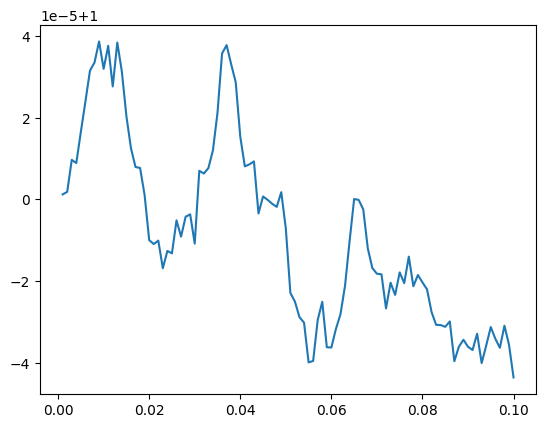

In [34]:
plt.plot(alpha_list, mean_strat_ret_list)

In [37]:
mean_strat_ret_list

[1.0000012241399177,
 1.0000018401472035,
 1.000009677911876,
 1.0000089118858602,
 1.0000165652515944,
 1.0000239718198602,
 1.0000315441637821,
 1.0000335434988445,
 1.0000386852713414,
 1.000031981798578,
 1.0000376197141072,
 1.0000276760993143,
 1.0000384193881005,
 1.000031314748135,
 1.0000203818557818,
 1.0000125365236991,
 1.0000079288637633,
 1.0000077061072337,
 1.0000010295831003,
 0.9999900276985948,
 0.9999890587018098,
 0.9999899039466124,
 0.9999831416067533,
 0.9999873741058608,
 0.9999867729959712,
 0.9999948628771509,
 0.9999908853827603,
 0.9999957469677422,
 0.9999963422819806,
 0.9999891698646995,
 1.0000069974742598,
 1.000006337973027,
 1.000007669213341,
 1.0000120347633852,
 1.0000212301194236,
 1.0000357391476489,
 1.00003779040431,
 1.0000331184502618,
 1.000028703214262,
 1.0000153628927344,
 1.0000080929316824,
 1.0000085794520142,
 1.0000093015654605,
 0.9999965566910199,
 1.0000007169640548,
 0.9999998921018594,
 0.9999989333586,
 0.9999981675051324,
 1.

it seems that no one alpha is higher than the risk free rate. we will use the alpha that maximize the mean return

In [38]:
alpha_list

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])

In [39]:
alpha_list[np.argmax(mean_strat_ret_list)]

0.009000000000000001

In [40]:
strat_ret = strat_ret_fun(alpha_list[np.argmax(mean_strat_ret_list)])

In [41]:
print(f'Expected value of the trade after three month: {np.mean(strat_ret[:, -1])}')

Expected value of the trade after three month: 1.0000386852713414


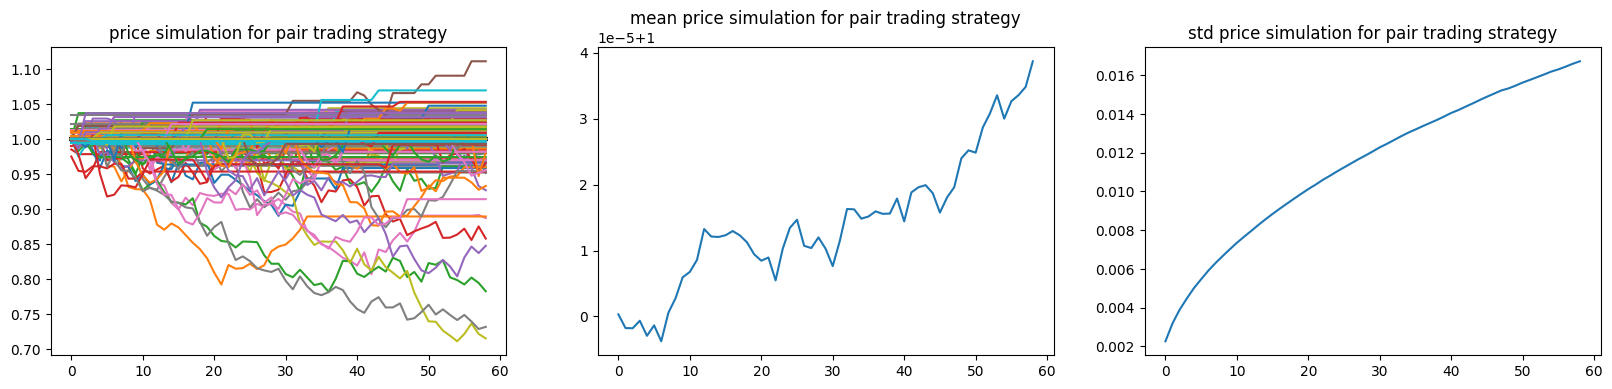

In [42]:
plot_simulations(strat_ret, 'pair trading strategy')

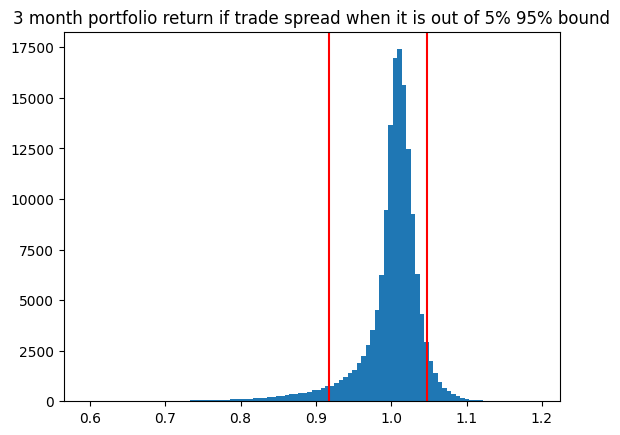

In [44]:
plt.hist(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], bins=100)# we discard the 1 return because it distort the histogram
plt.axvline(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.05), color='r')
plt.axvline(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.95), color='r')
plt.title('3 month portfolio return if trade spread when it is out of 5% 95% bound')
plt.show()

In [61]:
print(f'value at the 5th percentile: {(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.05)-1)*100}%')
print(f'value at the 95th percentile: {(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.95)-1)*100}%')

value at the 5th percentile: -8.200419127759895%
value at the 95th percentile: 4.791541953123568%


# Extra: Simulating the spread using Ornstein-Uhlenbeck process

<Axes: xlabel='Date'>

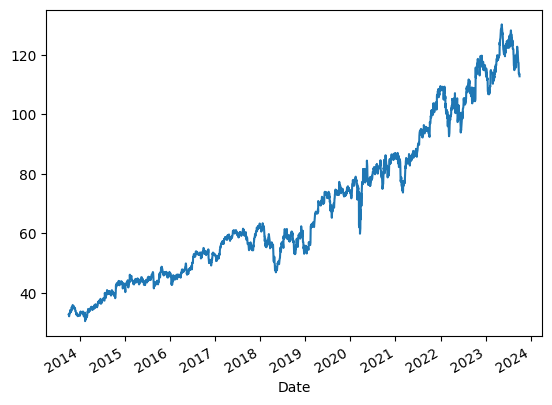

In [209]:
historical_spread.plot()

In [210]:
sTrend = historical_spread[0] + historical_spread.mean() * np.linspace(0, 1, len(historical_spread))

Text(0.5, 1.0, 'spread minus trend')

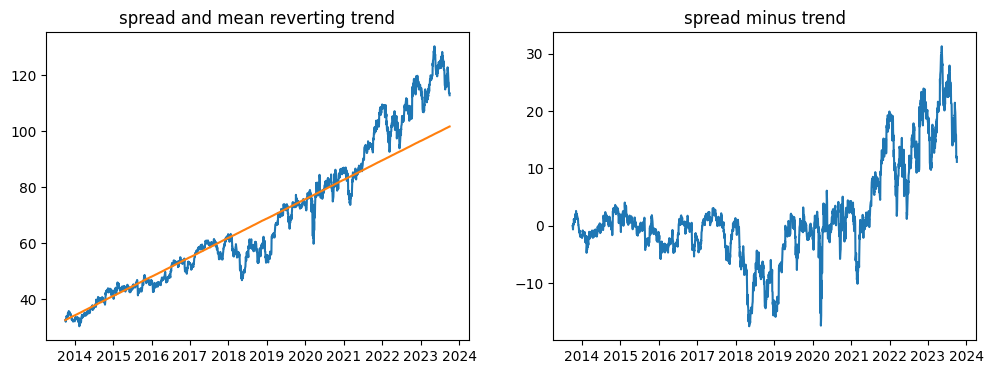

In [211]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historical_spread)
plt.plot(pd.DataFrame(sTrend, index=historical_spread.index))
plt.title('spread and mean reverting trend')
plt.subplot(1, 2, 2)
plt.plot(historical_spread - sTrend)
plt.title('spread minus trend')

C:\Users\kevin\AppData\Local\Temp\ipykernel_11812\1944201806.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf)), acf, use_line_collection=True)


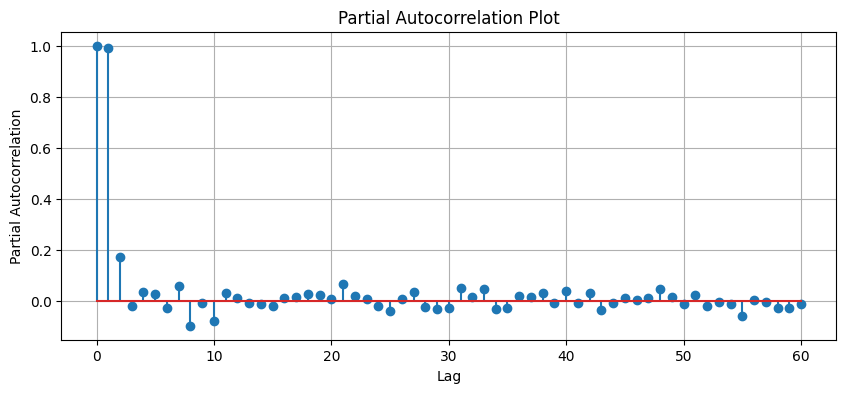

In [212]:
# partial autocorrelation plot
import statsmodels.api as sm

acf = sm.tsa.pacf(historical_spread - sTrend, nlags=60)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf)), acf, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.grid()
plt.show()

In [213]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()

In [214]:
U = np.random.uniform(size=(10000, len(historical_spread)))
dW = ss.norm.ppf(U)
XOU = np.zeros(U.shape)
XOU[:, 0] = 0

In [215]:
a = 0.005

In [216]:
for i in range(1, len(historical_spread)):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

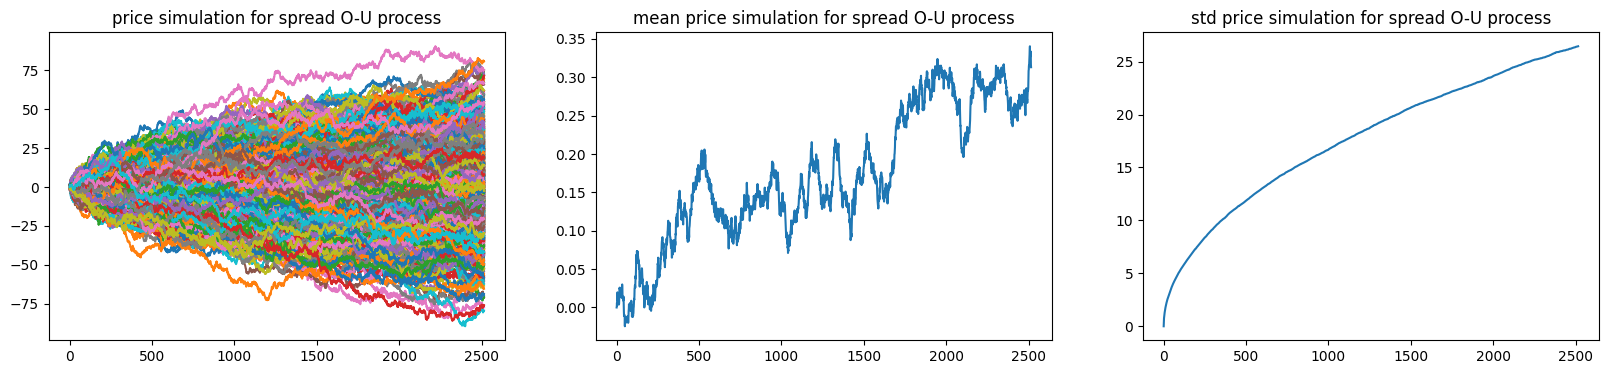

In [217]:
plot_simulations(XOU, 'spread O-U process')

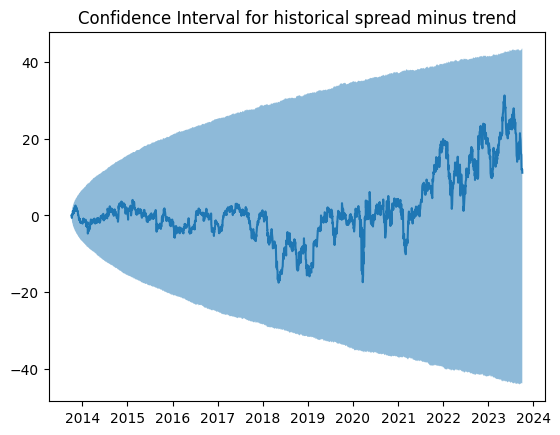

In [218]:
plt.plot(historical_spread - sTrend)
plt.fill_between(historical_spread.index, np.quantile(XOU, 0.05, axis=0), np.quantile(XOU, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread minus trend')
plt.show()

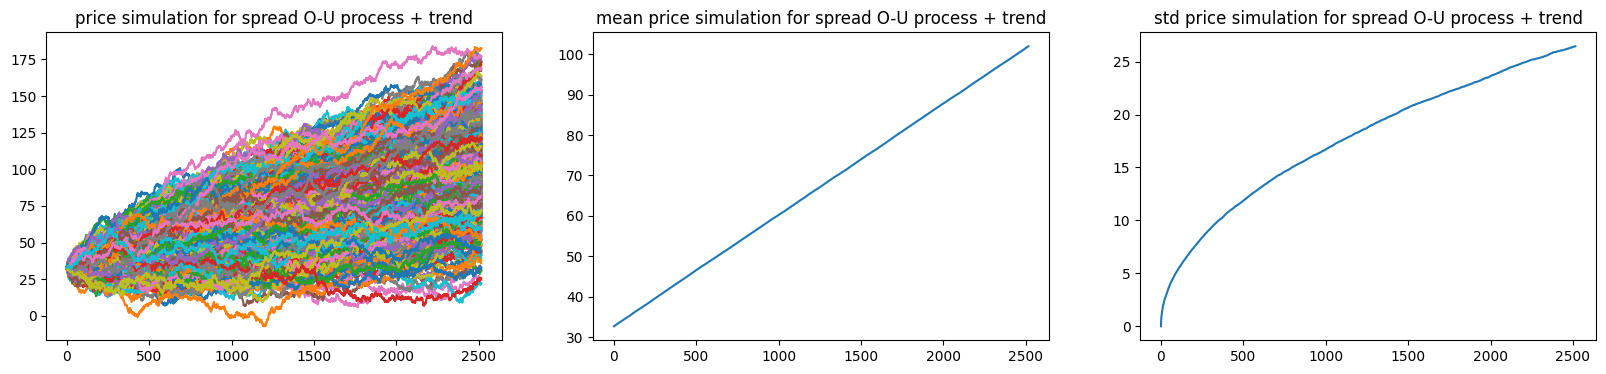

In [219]:
plot_simulations(XOU + sTrend, 'spread O-U process + trend')

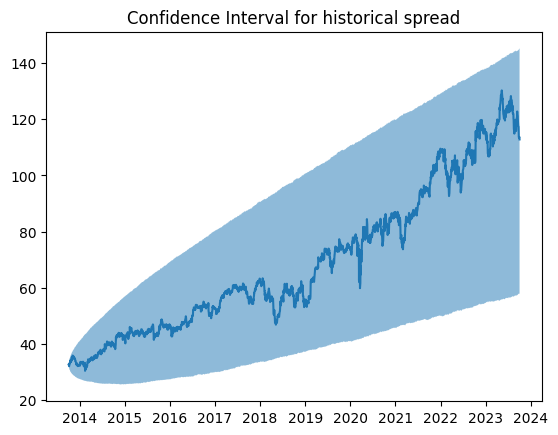

In [220]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index, np.quantile(XOU + sTrend, 0.05, axis=0),
                 np.quantile(XOU + sTrend, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()

# Extra Extra: OU Process with correlation

In [221]:
NTrials = 10000

In [222]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()
U1 = np.random.uniform(size=(NTrials, len(historical_spread)))
U2 = np.random.uniform(size=(NTrials, len(historical_spread)))
dW_1 = ss.norm.ppf(U1)
dW_2 = ss.norm.ppf(U2)
for i in range(NTrials):
    temp = np.stack([dW_1[i], dW_2[i]]).T @ L.T
    dW_1[i], dW_2[i] = temp[:, 0], temp[:, 1]
dW = dW_2 - dW_1
XOU = np.zeros(dW.shape)
XOU[:, 0] = 0
a = 0.005

In [223]:
for i in range(1, len(historical_spread)):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

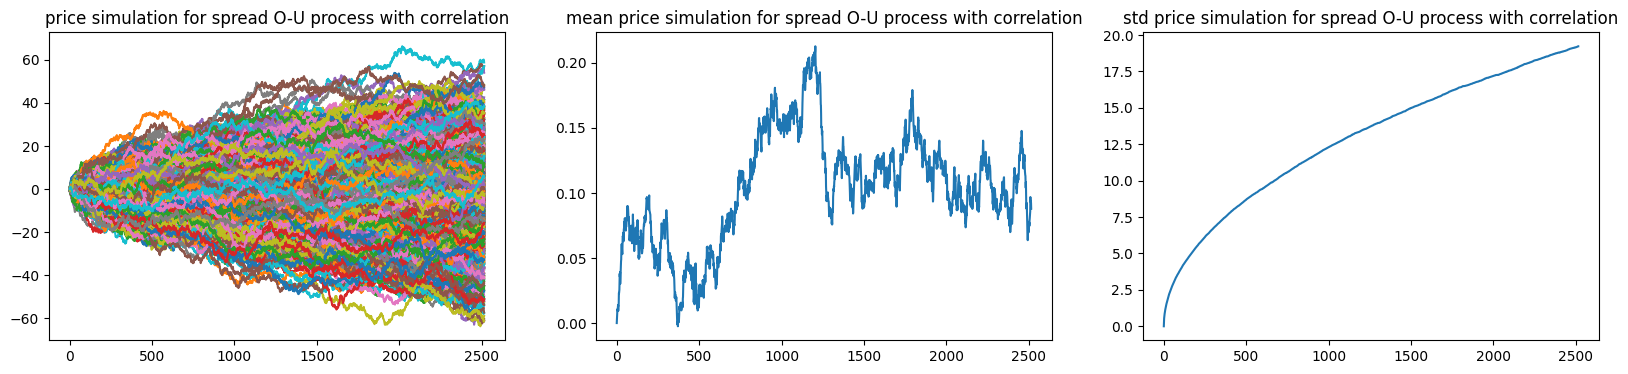

In [224]:
plot_simulations(XOU, 'spread O-U process with correlation')

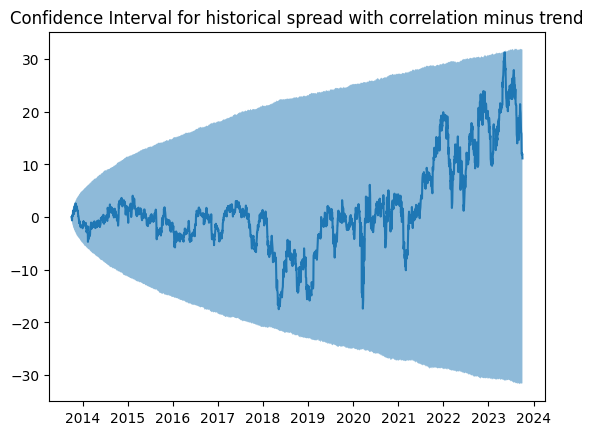

In [225]:
plt.plot(historical_spread - sTrend)
plt.fill_between(historical_spread.index, np.quantile(XOU, 0.05, axis=0), np.quantile(XOU, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread with correlation minus trend')
plt.show()

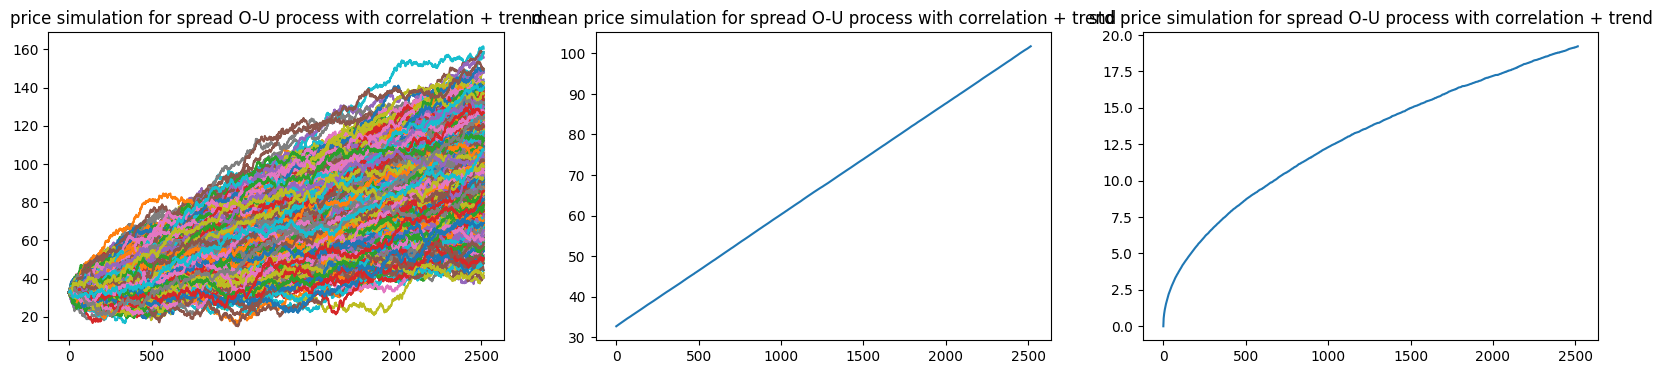

In [226]:
plot_simulations(XOU + sTrend, 'spread O-U process with correlation + trend')

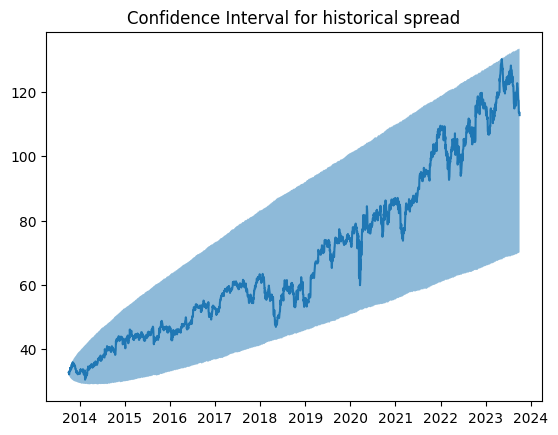

In [227]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index, np.quantile(XOU + sTrend, 0.05, axis=0),
                 np.quantile(XOU + sTrend, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()